В цій практичній роботі ми спробуємо реалізувати нейронну мережу з двох шарів (прихований і вихідний). Запропонований підхід стане заготовкою для реалізації наступних оптимізацій: MBGD, ADAM та регуляризації. 

Сьогодні ж вам пропонується додати до цього класу підтримку довільної кількості шарів та нейронів в них (наприклад, передавати їх параметром в конструктор, як це робиться в MLPClassifier за допомогою hidden_layer_sizes). Також потрібно передбачити можливість ранньої зупинки ітераційного процесу, якщо значення штрафної функції не покращуватиметься протягом певної кількості ітерацій. Наприклад, якщо протягом $k$ ітерацій штрафна функція за модулем не стане меншою, ніж на поточному кроці.

In [52]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
%matplotlib inline
from sklearn.metrics import accuracy_score

import sklearn.linear_model

In [53]:
def plot_surface(cls, x_1, x_2, ax=None, threshold=0.5, contourf=False):
    xx1, xx2 = np.meshgrid(np.linspace(x_1.min(), x_1.max(), 100), 
                           np.linspace(x_2.min(), x_2.max(), 100))

    X_pred = np.c_[xx1.ravel(), xx2.ravel()]
    pred = cls.predict_proba(X_pred)[:, 0]
    Z = pred.reshape((100, 100))
    if ax is None:
        ax = plt.gca()
    ax.contour(xx1, xx2, Z, levels=[threshold], colors='black')
    ax.set_xlim((x_1.min(), x_1.max()))
    ax.set_ylim((x_2.min(), x_2.max()))

In [54]:
def plot_data(X, y):
    ax = plt.gca()
    ax.scatter(X[:,0], X[:,1], c=(y == 1), cmap=cm_bright)

In [161]:
class NeuralNet:
    """
    NN for binary classification
    Attributes:
    ...
    """
    
    def __init__(self, normalize = True, learning_rate = 0.01, num_iter = 30000,
                 hidden_layer_sizes =(5,10),not_improve_iters =500,tol =1e-10):
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.normalize = normalize
        
        self.hidden_layer_sizes =hidden_layer_sizes;
        self.layers_count =len(hidden_layer_sizes);
        
        self.not_improve_iters =not_improve_iters;
        self.tol =tol;
    
    def __normalize(self, X, mean = None, std = None):
        """
        Зверніть увагу, що нормалізація вхідних даних є дуже важливою для швидкодії нейронних мереж.
        """
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
        X_new = (X - m) / s**2
        return X_new, m, s

    def __sigmoid(self, Z):
        """
        В наступних практичних потрібно буде додати підтримку й інших активаційних функцій - це один з гіперпараметрів. 
        Їх можна вибирати для всіх шарів одночасно або мати різні активаційні функції на кожному з них.
        """
        return 1 / (1 + np.exp(-Z))
    
    def __softmax(self,Z):
        return np.exp(Z)/np.sum(np.exp(Z),axis=1,keepdims=True)
    
    def __initialize_parameters(self, n_x, n_arr):
        layers =len(n_arr);
        W_arr =[];
        b_arr =[];
        #Init first layer
        W_first = np.random.randn(n_arr[0], n_x) * 0.01;
        b_first = np.zeros((n_arr[0], 1));
        W_arr.append(W_first);
        b_arr.append(b_first);
        
        # Перебрати всі слої окрім першого та останнього
        for n_l in range(1,layers):
            W_temp =np.random.randn(n_arr[n_l], n_arr[n_l-1]) * 0.01;
            b_temp = np.zeros((n_arr[n_l], 1));
            W_arr.append(W_temp);
            b_arr.append(b_temp);
        
        #Init last layer
        W_last =np.random.randn(1, n_arr[layers-1]) * 0.01
        b_last = 0;# The last layer has only one neuron
        
        W_arr.append(W_last);
        b_arr.append(b_last);
        
        print("Init parameters.")
        print("W coefs len: ",len(W_arr)," b coefs len: ",len(b_arr));
        
        for w_debug in W_arr:
            print("W shape: ",w_debug.shape);
        
        self.parameters = {"W_arr" : W_arr, "b_arr" : b_arr}
       
    def __forward_propagation(self, X):
        
        W_arr =self.parameters["W_arr"]
        b_arr = self.parameters["b_arr"]
        
        W_first = W_arr[0];
        b_first = b_arr[0];
        
        W_last =W_arr[len(W_arr)-1];
        b_last =b_arr[len(b_arr)-1];
        
        Z_arr =[];
        A_arr =[];
        
        Z_first =np.dot(W_first,X)+b_first;
        A_first = self.__sigmoid(Z_first);
        #A_first =self.__softmax(Z_first);
        
        Z_arr.append(Z_first);
        A_arr.append(A_first);
        
        layers = self.layers_count;
#         for l in range(1,layers+1):#range(1,layers) -> range(1,layers+1)
#             Z_temp = np.dot(W_arr[l],A_arr[l-1])+b_arr[l];
#             A_temp = self.__sigmoid(Z_temp);
#             Z_arr.append(Z_temp);
#             A_arr.append(A_temp);
            
        for l in range(1,layers):
            Z_temp = np.dot(W_arr[l],A_arr[l-1])+b_arr[l];
            A_temp = self.__sigmoid(Z_temp);
            Z_arr.append(Z_temp);
            A_arr.append(A_temp);
            
        last_index = layers;
        Z_temp = np.dot(W_arr[last_index],A_arr[last_index-1])+b_arr[last_index];
        A_temp = self.__softmax(Z_temp);
        Z_arr.append(Z_temp);
        A_arr.append(A_temp);
        
        
        cache =(W_arr,b_arr,Z_arr,A_arr);
        
        return A_arr[-1], cache
    
#     def compute_cost(self, A, Y):
#         m = Y.shape[1]
#         res = Y * np.log(A) + (1 - Y) * np.log(1 - A)
#         J = -(1 / m) * np.sum(res)
#         return J
    def compute_cost(self, A, Y):
        m = Y.shape[1]
        res = Y * np.log(A) + (1 - Y) * np.log(1 - A)
        J = -(1 / m) * np.sum(res)
        return J
        
    def __backward_propagation(self, X, Y, cache):
        m = X.shape[1]
        n = X.shape[0]
        (W_arr,b_arr,Z_arr,A_arr) = cache
        
        
        dZ_arr=[];
        dW_arr =[];
        dA_arr=[];
        db_arr =[];
        
        dZ_last = A_arr[-1] -Y;# Get last A
        #dW_last = 1. / m * np.dot(dZ_last, A_arr[-2].T);
        dW_last = 1. / m * np.dot(dZ_last, A_arr[-2].T);
        db_last =1. / m * np.sum(dZ_last, axis = 1, keepdims = True);
        dA_last =np.dot(W_arr[-1].T,dZ_last);
        
        dZ_arr.insert(0,dZ_last); # insert value at front
        dW_arr.insert(0,dW_last);
        db_arr.insert(0,db_last);
        dA_arr.insert(0,dA_last);
        
        for l_inv in range(len(W_arr)-2,0,-1):
            
            dZ_temp =np.multiply(dA_arr[0], np.multiply(A_arr[l_inv], 1 - A_arr[l_inv])); #A_arr[l_inv] ->A_arr[l_inv-1]
            dW_temp =1. / m * np.dot(dZ_temp, A_arr[l_inv-1].T);#A_arr[l_inv] ->A_arr[l_inv-1]
            
            
            db_temp =1. / m * np.sum(dZ_temp, axis = 1, keepdims = True);
            
            dA_temp =np.dot(W_arr[l_inv].T,dZ_temp);
            
            dZ_arr.insert(0,dZ_temp);
            dW_arr.insert(0,dW_temp);
            dA_arr.insert(0,dA_temp);
            db_arr.insert(0,db_temp);
        
        
        dA_first =dA_arr[0];
        dZ_first = np.multiply(dA_first, np.multiply(A_arr[0], 1 - A_arr[0]));
        #dZ_dirst =np.multiply(dA_arr[0],);
        dW_first = 1. / m * np.dot(dZ_first,X.T)
        db_first =1. / m * np.sum(dZ_first, axis = 1, keepdims = True)
        
        dZ_arr.insert(0,dZ_first); # insert value at front
        dW_arr.insert(0,dW_first);
        db_arr.insert(0,db_first);

        grads ={"dZ_arr":dZ_arr,"dW_arr":dW_arr,"db_arr":db_arr}
        return grads
    
    def __update_parameters(self, grads):
        W_arr =self.parameters["W_arr"];
        b_arr =self.parameters["b_arr"];
        
        dW_arr =grads["dW_arr"];
        db_arr =grads["db_arr"];
        
        W_new_arr =W_arr.copy();
        b_new_arr = b_arr.copy();
        for l in range(0,len(W_arr)):
            W_new_arr[l]-=self.learning_rate * dW_arr[l];
            b_new_arr[l]-=self.learning_rate * db_arr[l];
        
        self.parameters["W_arr"] = W_new_arr;
        self.parameters["b_arr"] = b_new_arr;
        
        
        
    def fit(self, X_vert, Y_vert, print_cost = True):
        
        X, Y = X_vert.T, Y_vert.T
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        
        costs = []
        improve_costs =[];
        m = X.shape[1]
        n_x = X.shape[0]
        
        self.__initialize_parameters(n_x,self.hidden_layer_sizes)

        for i in range(self.num_iter):
            A, cache = self.__forward_propagation(X)
            
            cost = self.compute_cost(A, Y)

            grads = self.__backward_propagation(X, Y, cache)

            self.__update_parameters(grads)
            
            if i%self.not_improve_iters ==0:
                improve_costs.append(cost);
                imp_len =len(improve_costs);
                if imp_len >2:
                    if abs(improve_costs[imp_len-1] - improve_costs[imp_len-2]) < self.tol:
                        return;
            
            
            
            if print_cost and i % 1000 == 0:
                print("{}-th iteration: {}".format(i, cost))

            if i % 1000 == 0:
                costs.append(cost)

        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration, *1000")
            plt.show()
    
    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
        
        probs = self.__forward_propagation(X)[0]
        
        return np.column_stack((probs.T, 1 - probs.T))
    
    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)[:, 0]
        return (positive_probs >= 0.5).astype(int)   


Спочатку спробуйте цей клас на одній задачі, а потім на іншій.

In [162]:
# data_columns = ["exam1", "exam2"]
# target_column = "submitted"
# df = pd.read_csv("sats.csv")
# X, Y = df[data_columns].values, df[target_column]
# print('Training set: X={}, y={}'.format(X.shape, Y.shape))

In [163]:
data_columns = ["test1", "test2"]
target_column = "passed"
df = pd.read_csv("tests.csv")
X, Y = df[data_columns].values, df[target_column]
print('Training set: X={}, y={}'.format(X.shape, Y.shape))

Training set: X=(118, 2), y=(118,)


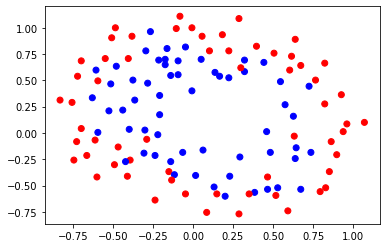

In [164]:
plot_data(X, Y)

In [171]:
cls = NeuralNet(normalize = True, learning_rate = 0.001, num_iter = 1000001,hidden_layer_sizes = (5,2),not_improve_iters=10000000,tol=1e-8)

In [172]:
cls.fit(X, Y.values.reshape((df.shape[0], 1)))

Init parameters.
W coefs len:  3  b coefs len:  3
W shape:  (5, 2)
W shape:  (2, 5)
W shape:  (1, 2)
0-th iteration: 2.349240257464708
1000-th iteration: 2.3492396139894534
2000-th iteration: 2.349237037841186
3000-th iteration: 2.3492298954349677
4000-th iteration: 2.349213131628262
5000-th iteration: 2.3491770755943557
6000-th iteration: 2.3491107555540838
7000-th iteration: 2.3490138459545102
8000-th iteration: 2.348901731043873
9000-th iteration: 2.3487940104174303
10000-th iteration: 2.3487030903106185
11000-th iteration: 2.3486329877436427
12000-th iteration: 2.3485828053146443
13000-th iteration: 2.3485496946654907
14000-th iteration: 2.3485303996516045
15000-th iteration: 2.3485218978070583
16000-th iteration: 2.348521613217197
17000-th iteration: 2.3485274463349666
18000-th iteration: 2.3485377315864993
19000-th iteration: 2.348551171578282
20000-th iteration: 2.348566769198774
21000-th iteration: 2.3485837663446816
22000-th iteration: 2.348601592123436
23000-th iteration: 2.3

208000-th iteration: 2.3491893174383076
209000-th iteration: 2.3491896121559424
210000-th iteration: 2.349189903713154
211000-th iteration: 2.349190192158841
212000-th iteration: 2.3491904775409167
213000-th iteration: 2.3491907599063433
214000-th iteration: 2.349191039301132
215000-th iteration: 2.3491913157704016
216000-th iteration: 2.3491915893583677
217000-th iteration: 2.3491918601083794
218000-th iteration: 2.3491921280629433
219000-th iteration: 2.3491923932637326
220000-th iteration: 2.349192655751621
221000-th iteration: 2.3491929155666864
222000-th iteration: 2.349193172748242
223000-th iteration: 2.3491934273348396
224000-th iteration: 2.3491936793643124
225000-th iteration: 2.3491939288737718
226000-th iteration: 2.3491941758996147
227000-th iteration: 2.3491944204775783
228000-th iteration: 2.349194662642707
229000-th iteration: 2.349194902429416
230000-th iteration: 2.3491951398714614
231000-th iteration: 2.349195375001993
232000-th iteration: 2.349195607853537
233000-th

KeyboardInterrupt: 

In [25]:
print(cls.parameters)

{'W_arr': [array([[ 0.0190773 , -0.01056006],
       [ 0.00901124, -0.02250764]]), array([[-0.0169716 , -0.00281749]])], 'b_arr': [array([[ 1.21660650e-04],
       [-9.83959658e-06]]), array([[-0.03373458]])]}


In [26]:
Y_prob = cls.predict_proba(X)
Y_prob

array([[0.49152258, 0.50847742],
       [0.49152524, 0.50847476],
       [0.49152785, 0.50847215],
       [0.49152727, 0.50847273],
       [0.49152554, 0.50847446],
       [0.49152585, 0.50847415],
       [0.49152666, 0.50847334],
       [0.49152147, 0.50847853],
       [0.49152307, 0.50847693],
       [0.49152605, 0.50847395],
       [0.49152459, 0.50847541],
       [0.49152578, 0.50847422],
       [0.49152504, 0.50847496],
       [0.49152666, 0.50847334],
       [0.49152499, 0.50847501],
       [0.49152175, 0.50847825],
       [0.49152757, 0.50847243],
       [0.49152262, 0.50847738],
       [0.49152426, 0.50847574],
       [0.49152268, 0.50847732],
       [0.49152643, 0.50847357],
       [0.49152635, 0.50847365],
       [0.49152705, 0.50847295],
       [0.491527  , 0.508473  ],
       [0.49152798, 0.50847202],
       [0.49152709, 0.50847291],
       [0.49152678, 0.50847322],
       [0.49152792, 0.50847208],
       [0.4915235 , 0.5084765 ],
       [0.49152358, 0.50847642],
       [0.

In [27]:
Y_hat = cls.predict(X)
Y_hat

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [28]:
accuracy_score(Y, Y_hat)

0.5084745762711864

<ipython-input-17-1d8d12161a03>:10: UserWarning: No contour levels were found within the data range.
  ax.contour(xx1, xx2, Z, levels=[threshold], colors='black')


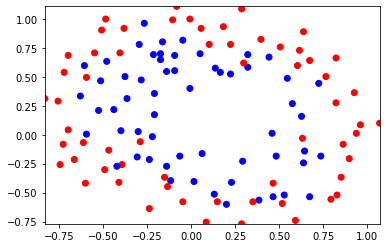

In [29]:
plot_data(X, Y)
plot_surface(cls, X[:, 0], X[:, 1])

Зверніть увагу на границю прийняття рішення. Модель старається побудувати складну криву, що може свідчити про її перетренування. Порівняйте отримані результати з класом з sklearn. Спробуйте додати нові шари для нашого класу та порівняти результати тоді. Поекспериментуйте з гіперпараметрами для обох класів.

In [393]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes = (8,), max_iter = 1000000, activation = 'relu', solver = 'sgd', learning_rate_init = 0.01, learning_rate = 'constant')

In [394]:
clf.fit(X, Y)

MLPClassifier(hidden_layer_sizes=(8,), learning_rate_init=0.01,
              max_iter=1000000, solver='sgd')

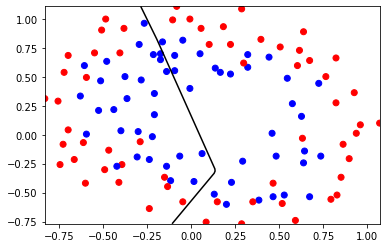

In [395]:
plot_data(X, Y)
plot_surface(clf, X[:, 0], X[:, 1])

In [396]:
accuracy_score(Y, clf.predict(X))

0.5423728813559322

In [397]:
clf.n_iter_

72